# **AB DATA**

Pel nostre anàlisi, només utilitzem el dataset 1: consum d'aigüa diari agregat per secció censal.

* **Font**: Data Challenge Aigües de Barcelona
* **URL**: https://www.abdatachallenge.cat/
* **Periodicitat**: diari (de 2019 a 2022)
* **Agregació geogràfica**: secció censal

Aquest notebook corregeix o elimina els outliers més evidents. Tot i que els outliers que eliminem puguin ser fuïtes o excesos de consum reals, el nostre anàlisi es centra en trobar desigualtats i patrons, així que aquests esdeveniments no ens són rellevants.

This notebook should take the original `dataset1_v2.csv`, clean the outliers, and return a new `dataset1_v2_outlier_clean.csv`.

In [1]:
# -- PRODUCTION --
ROOT = "/content/drive/Shareddrives/GESTIÓ DE PROJECTES/X. Entregable/"
AB_DATASET_FILE = ROOT + "cleaning/raw_data/dataset1_v2.csv"
DATASET_CLEAN_FILE = ROOT + "cleaning/clean_data/outlierfree_dataset_v1.csv"

In [2]:
# -- PRODUCTION --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importar dataset

In [3]:
# -- PRODUCTION --
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# -- PRODUCTION --

data_types = {"Secció Censal/Sección censal/Census section":str,
             "Districte/Distrito/District":str,
             "Codi postal/Código postal/Postcode":str}

renames = {
    "Secció Censal/Sección censal/Census section": "CUSEC",
    "Districte/Distrito/District": "district",
    "Codi postal/Código postal/Postcode": "postcode",
    "Municipi/Municipio/Municipality": "municipality",
    "Data/Fecha/Date": "date",
    "Ús/Uso/Use": "use",
    "Nombre de comptadors/Número de contadores/Number of meters": "num_comptadors",
    "Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)": "consumption_L_day"
}

original_dataset = pd.read_csv(AB_DATASET_FILE, dtype=data_types)
original_dataset = original_dataset[original_dataset["Ús/Uso/Use"]=="Domèstic/Doméstico/Domestic"]
original_dataset['Data/Fecha/Date'] = pd.to_datetime(original_dataset['Data/Fecha/Date'])
original_dataset = original_dataset.rename(columns=renames)
original_dataset = original_dataset.dropna(subset=['CUSEC']).reset_index(drop=True)

# Eliminar idiomes
original_dataset['use'] = original_dataset['use'].str.split('/').str[-1]
original_dataset["consumption_per_house"] = original_dataset["consumption_L_day"]/original_dataset["num_comptadors"]

In [5]:
# -- VISUALIZATION --

original_dataset.head()

,CUSEC,district,postcode,municipality,date,use,num_comptadors,consumption_L_day,consumption_per_house
0,0801901001,01,08001,BARCELONA,2019-01-01,Domestic,172,35592.0,206.930233
1,0801901001,01,08001,BARCELONA,2019-01-02,Domestic,172,37309.0,216.912791
2,0801901001,01,08001,BARCELONA,2019-01-03,Domestic,172,37013.0,215.191860
3,0801901001,01,08001,BARCELONA,2019-01-04,Domestic,172,37951.0,220.645349
4,0801901001,01,08001,BARCELONA,2019-01-05,Domestic,172,39591.0,230.180233


In [6]:
# -- VISUALIZATION --

original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011392 entries, 0 to 2011391
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   CUSEC                  object        
 1   district               object        
 2   postcode               object        
 3   municipality           object        
 4   date                   datetime64[ns]
 5   use                    object        
 6   num_comptadors         int64         
 7   consumption_L_day      float64       
 8   consumption_per_house  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 138.1+ MB


In [7]:
# -- VISUALIZATION --

print("Number of NaN's:")
print(original_dataset.isna().sum())

Number of NaN's:
CUSEC                    0
district                 0
postcode                 0
municipality             0
date                     0
use                      0
num_comptadors           0
consumption_L_day        0
consumption_per_house    0
dtype: int64


In [8]:
# -- VISUALIZATION --

def visualize_outliers(dirty_dataset, clean_dataset=None):
    fig, ax = plt.subplots(1, figsize=(18, 6))
    plt.plot(np.array(dirty_dataset["date"]), np.array(dirty_dataset["consumption_per_house"]), label='Original Consumption', color='red')
    if clean_dataset is not None:
      plt.plot(np.array(clean_dataset["date"]), np.array(clean_dataset["consumption_per_house"]), label='Smoothed Consumption', color='blue')
    plt.legend()
    plt.plot(np.array(dirty_dataset["date"]), np.zeros(len(dirty_dataset)), c="black", linestyle="--")
    plt.show()

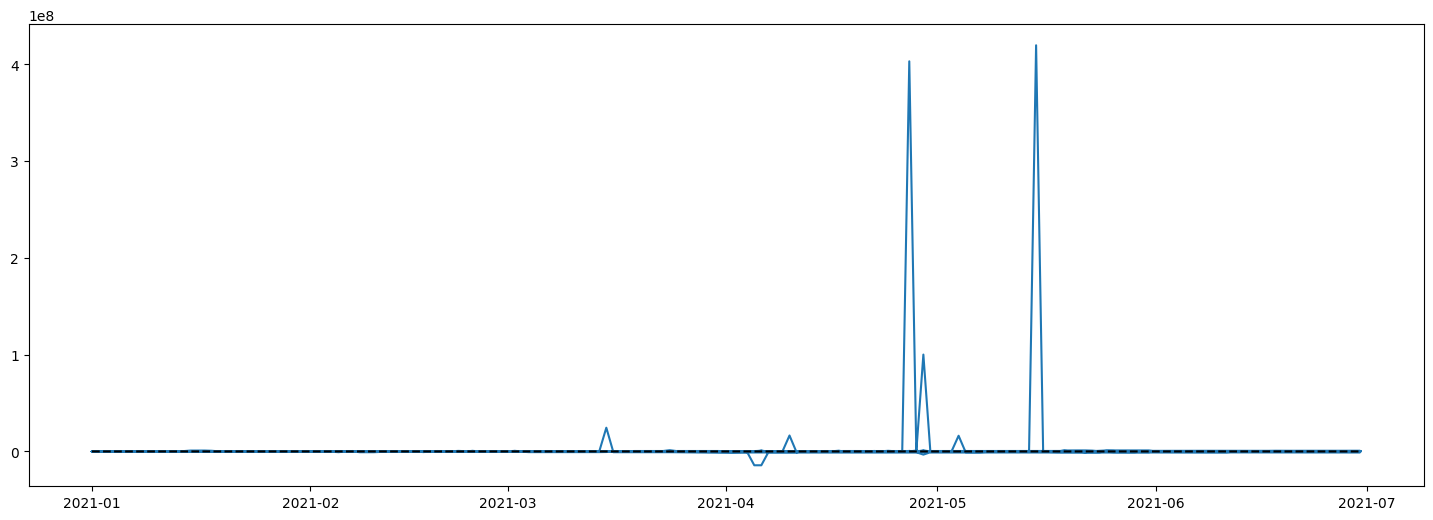

In [9]:
# -- VISUALIZATION --

# We can observe that in the plot above, there are huge outliers in the first half of 2021
# En aquest informe: https://www.bcasa.cat/PDF/Consum_Aigua2021.pdf, podem veure que no hi va haver un consum exagerat durant aquest període
# Filtered data for the first six months of 2021
fig, ax = plt.subplots(1, figsize=(18,6))
big_outlier_data = original_dataset[(original_dataset['date'] >= '2021-01-01') & (original_dataset['date'] <= '2021-06-30') & (original_dataset["use"] == "Domestic")]

plt.plot(np.array(big_outlier_data["date"]), np.array(big_outlier_data["consumption_L_day"]))
plt.plot(np.array(big_outlier_data["date"]), np.zeros(len(big_outlier_data)), c="black", linestyle="--")

plt.show()

## Outlier cleaning

### Tipus d'outliers

De moment, volem ser conservadors a l'hora de retirar outliers. Si més endevant trobem que embruten massa l'anàlisi, en treurem més.

Hem trobat alguns outliers molt obvis:

* ERRORS RECTIFICATS AL DIA SEGÜENT: Trobem molts valors exageradament alts on al dia següent hi ha valors negatius. Es a dir, un dia hi ha hagut un consum surrealistament alt, i al següent dia un consum negatiu. Aixó té pinta que són errors de mesura on Aigües de Bcn rectifica aplicant una lectura negativa al dia següent.
    * Exemples d'aquest cas:
        * CUSEC 0830102017, a Viladecans, entre el 1-Nov-2019 al 6-Nov-2019
        * CUSEC 0808902010, a Gavà, entre el 24-Nov-2020 al 1-Dec-2020
        * CUSEC 0808901003, a Gavà, entre el 28-Abr-2022 al 3-May-2022 (en aquest cas és al contrari: primer la mesura negativa i al dia següent la positiva)
        * CUSEC 0801902132, al Eixample, entre el 8-May-2020 al 14-May-2020
        * CUSEC 0801907020, a Horta-Guinardo, entre el 1-Gen-2022 al 8-Gen-2022
        * CUSEC 0801908108, a Nou Barris, entre el 23-Nov-2022 al 30-Nov-2022 (aquest cas es moooolt sutil)
        
* ABISMOS:


* CASOS MÉS ESTRANYS ENCARA:
    * CUSEC 0801904051, a les Corts, entre el 1-Oct-2021 al 31-Gen-2021

In [10]:
# -- PRODUCTION --

from scipy import stats

def clean_statistical_outliers(timeseries_cs, std_limit = 10):
  """
  In statistics, a z-score tells us how many standard deviations away a value is from the mean.
  """
  # Utilizarem una nova columna que sigui smoothed per no substituir directament quan fem probes
  z_scores = np.abs(stats.zscore(timeseries_cs['consumption_per_house']))
  timeseries_cs['Is_Outlier'] = z_scores >= std_limit

  return timeseries_cs

In [11]:
# -- PRODUCTION --

def clean_up_and_down_outliers(timeseries_cs, std_limit = 2):
    timeseries_cs = timeseries_cs.reset_index(drop=True)
    z_scores = np.abs(stats.zscore(timeseries_cs['consumption_per_house']))
    for i in range(1, len(timeseries_cs)-1):
        current_value = timeseries_cs.at[i, 'consumption_per_house']

        if current_value < 0:
            if (timeseries_cs.at[i, 'date'] - timeseries_cs.at[i-1, 'date']).days == 1:
                previous_value = timeseries_cs.at[i - 1, 'consumption_per_house']
                if z_scores[i-1] >= std_limit:
                    # Correct negative value by redistributing the error to the previous day
                    correction = (current_value + previous_value)/2
                    timeseries_cs.at[i, 'consumption_per_house'] = np.nan
                    timeseries_cs.at[i - 1, 'consumption_per_house'] = np.nan
                elif abs((timeseries_cs.at[i, 'date'] - timeseries_cs.at[i+1, 'date']).days) == 1:
                    next_value = timeseries_cs.at[i + 1, 'consumption_per_house']
                    if z_scores[i+1] >= std_limit:
                        # Correct negative value by redistributing the error to the previous day
                        correction = (current_value + next_value)/2
                        timeseries_cs.at[i, 'consumption_per_house'] = np.nan
                        timeseries_cs.at[i + 1, 'consumption_per_house'] = np.nan
    return timeseries_cs

# Execució

In [12]:
# -- PRODUCTION --

# List to store clean signals
import warnings
warnings.filterwarnings('ignore')
cleaned_signals = original_dataset.groupby('CUSEC').apply(clean_up_and_down_outliers).reset_index(drop=True)
cleaned_signals = cleaned_signals.groupby('CUSEC').apply(clean_statistical_outliers).reset_index(drop=True)
cleaned_signals['consumption_per_house'] = cleaned_signals['consumption_per_house'].apply(lambda x: x if x>0 else np.nan)
cleaned_signals = cleaned_signals.dropna()

In [13]:
# -- PRODUCTION --

outlier_free_dataframe = cleaned_signals[cleaned_signals["Is_Outlier"] == False].drop(columns=['Is_Outlier'])

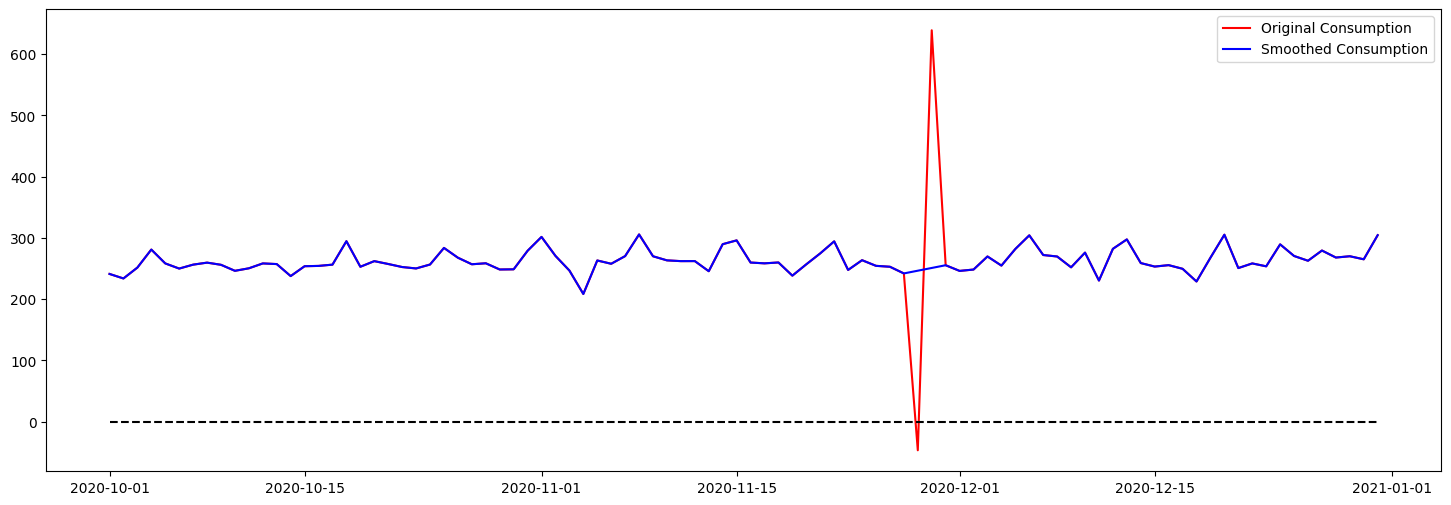

In [14]:
# -- VISUALIZATION --

example_outlier_dirty = original_dataset[(original_dataset['CUSEC'] == '0808902010')&(original_dataset['date'].dt.year==2020)&(original_dataset['date'].dt.month>9)]
example_outlier_clean = outlier_free_dataframe[(outlier_free_dataframe['CUSEC'] == '0808902010')&(outlier_free_dataframe['date'].dt.year==2020)&(outlier_free_dataframe['date'].dt.month>9)]

visualize_outliers(example_outlier_dirty, example_outlier_clean)

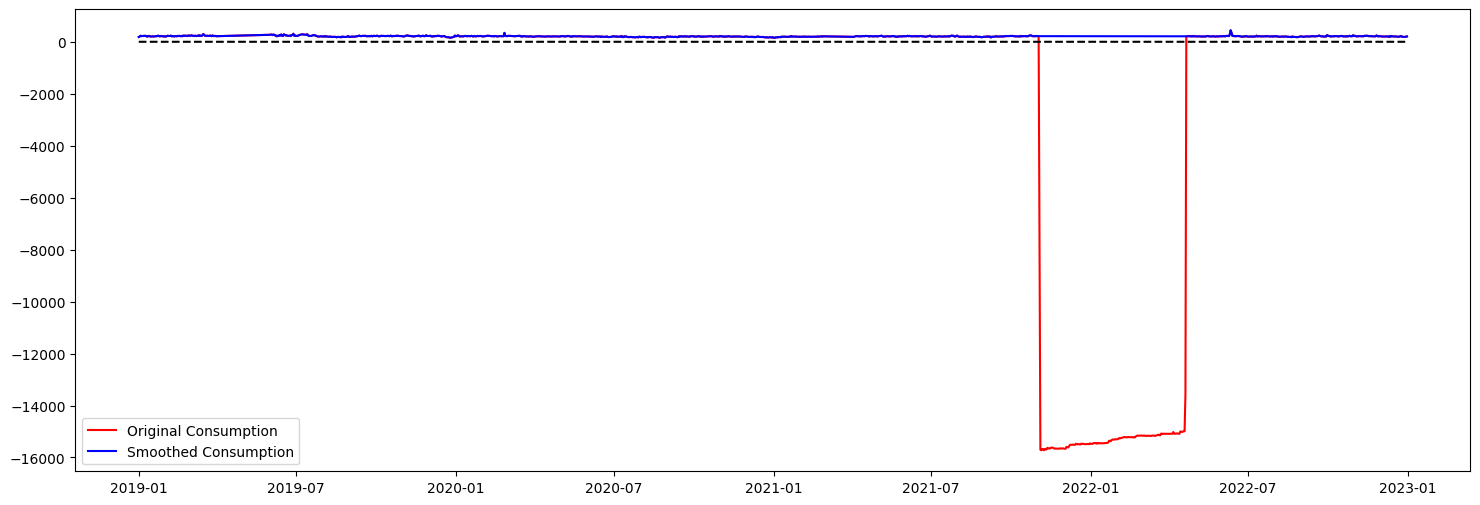

In [15]:
# -- VISUALIZATION --

example_outlier_dirty = original_dataset[(original_dataset['CUSEC'] == '0801901025')]
example_outlier_clean = outlier_free_dataframe[(outlier_free_dataframe['CUSEC'] == '0801901025')]

visualize_outliers(example_outlier_dirty, example_outlier_clean)

## Visualization tools

Index(['date', 'num_comptadors', 'consumption_L_day', 'consumption_per_house'], dtype='object')

Index(['date', 'num_comptadors', 'consumption_L_day', 'consumption_per_house'], dtype='object')

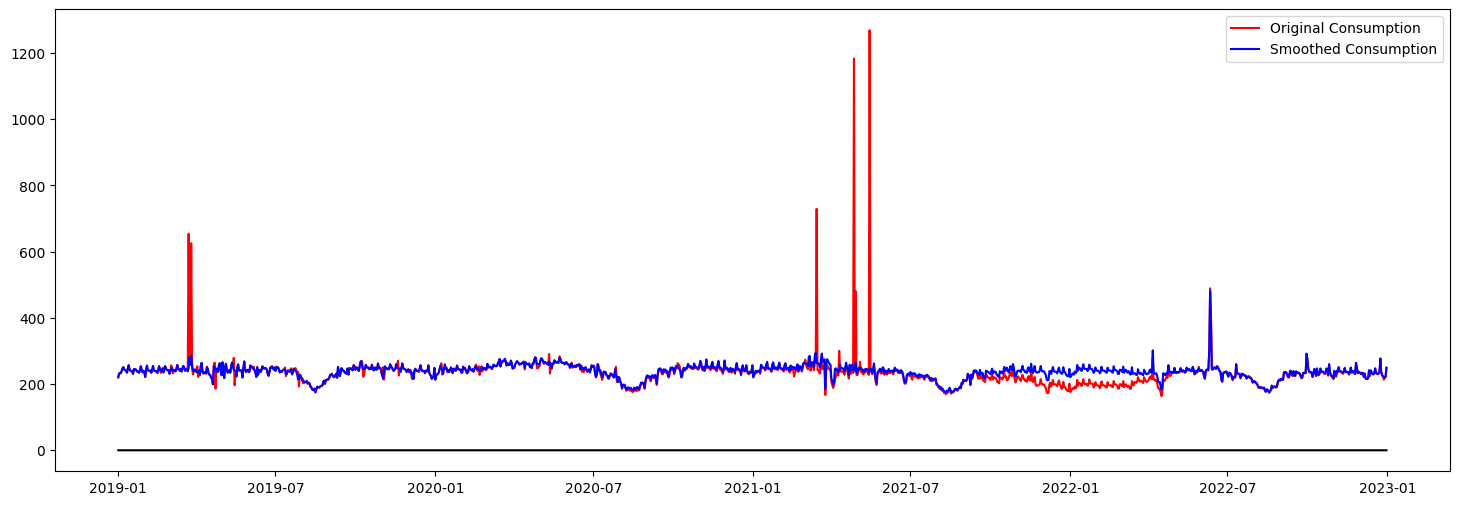

In [16]:
original_df = original_dataset.groupby('date').mean().reset_index()
cleaned_df = outlier_free_dataframe.groupby('date').mean().reset_index()

display(original_df.columns)
display(cleaned_df.columns)

fig, ax = plt.subplots(1, figsize=(18, 6))
plt.plot(np.array(original_df["date"]), np.array(original_df["consumption_per_house"]), label='Original Consumption', color='red')
plt.plot(np.array(cleaned_df["date"]), np.array(cleaned_df["consumption_per_house"]), label='Smoothed Consumption', color='blue')
plt.plot(np.array(cleaned_df["date"]), np.zeros(len(cleaned_df)), c="black")
# plt.ylim(0, 20000)
plt.legend()
plt.show()

## Export the outlier free dataframe

In [17]:
outlier_free_dataframe.to_csv(DATASET_CLEAN_FILE, index=False)